# **Final project explainer notebook - An analysis of trends and patterns in NYC shootings in the time period 2006-2023**


---
_By Bastian Gulstad Ravn (s214727)_ <br>
_Course: 02806 Social Data Analysis and Visualization_ <br>
_Technical University of Denmark_  <br>
_May 13, 2025_

---

## **Table of Contents**

1. [Motivation](#motivation)
2. [Basic stats](#basic_stats)
3. [Data Analysis](#data_analysis)
4. [Genre](#genre)
5. [Visualizations](#visualizations)
6. [Discussion](#discussion)
7. [Contributions](#contributions)
8. [References](#references)
---

<a id='motivation'></a>
## **1. Motivation**

The core dataset for this project is the historic NYPD Shooting Incident Data which is freely available on the NYC OpenData portal. A link to the website can be found [here](https://data.cityofnewyork.us/Public-Safety/NYPD-Shooting-Incident-Data-Historic-/833y-fsy8/about_data). The dataset contains reports of every shooting incident in New York City in the time period 2006-2023. It contains 21 columns and approximately 29000 rows. The columns contain a number of interesting features including but not limited to the date and time of the shooting, the NYC Borough in which the shooting occured, latitude and longitude, whether the shooting resulted in a death and demographic information on both the victim and the perpetrator. It should be noted that the dataset contains a significant share of missing values in perpetrator information features, which stems from the fact that not every perpetrator is seen/caught and hence described in the crime report.

I chose this particular dataset for multiple reasons. First of all, because it is large enough to allow for deep and thorough analysis and contains many interesting features that enable the possibility for many different visualization tools to be applied. It includes both temporal data, spatial data and demographic data which gives way for usage of an interesting combination of information for each shooting incident. Furthermore, I find the topic extremely interesting. Crime as a whole is a major topic in many forms of media and analytical study, and with gun crime being one of the most dangerous forms of crime that one can potentially witness/experience, it is interesting to investgiate what kind of insights we can find related to shootings in a major city such as NYC.

The goal for the end user's experience with this project is to provide a concise and descriptive presentation of the insights obtained from the analysis of the dataset. A focus will be put on using clean and relevant visualizations that will help deepen the reader's understanding of the data. Additionally, the presented analysis should maintain simplicity but still be interesting enough that it keeps the attention of the reader.

<a id='basic_stats'></a>
## **2. Basic stats**

### **Data cleaning and preprocessing**

In [73]:
# import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy import stats

# load data
data_path = "data/NYPD_Shooting_Incident_Data__Historic__20250414.csv"
df = pd.read_csv(data_path)

# main plot color
main_col = "#62bd84"

# secondary plot color
sec_col = "#493D9E"

# matplotlib font
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Arial"]

For this project, we will only be using a subset of the 21 total columns contained in this dataset. Furthermore, we reconfigure some column formats and rename most columns for consistency. Duplicate rows/shooting incidents are removed such that each value in the "INCIDENT_KEY" column is unique. "year" and "month" columns are added to the dataset based on the "date" column.

In [74]:
# select subset of columns to use
df = df[["INCIDENT_KEY", "OCCUR_DATE", "OCCUR_TIME", "BORO", "PRECINCT",
         "LOCATION_DESC","STATISTICAL_MURDER_FLAG","PERP_AGE_GROUP", "PERP_SEX", "PERP_RACE",
         "VIC_AGE_GROUP", "VIC_SEX", "VIC_RACE", "Latitude", "Longitude"]]

# convert date to datetime format
df["OCCUR_DATE"] = pd.to_datetime(df["OCCUR_DATE"])

# rename columns
df = df.rename(columns={"OCCUR_DATE": "date", "OCCUR_TIME": "time", "BORO": "boro",
                        "PRECINCT": "precinct", "LOCATION_DESC": "location_desc",
                        "PERP_AGE_GROUP": "perp_age_group", "PERP_SEX": "perp_sex", "PERP_RACE": "perp_race",
                        "VIC_AGE_GROUP": "vic_age_group", "VIC_SEX": "vic_sex", "VIC_RACE": "vic_race",
                        "Latitude": "latitude", "Longitude": "longitude"})


In [75]:
print(f"Number of rows before removal of duplicates: {len(df)}")

Number of rows before removal of duplicates: 28562


In [76]:
# remove duplicate entries by keeping only the first encountered row for each incident key value
agg_func = {'INCIDENT_KEY': 'first', 'date': 'first', 'time': 'first',
            'boro': 'first', 'precinct': 'first', 'location_desc': 'first',
            'STATISTICAL_MURDER_FLAG': 'first', 'perp_age_group': 'first', 'perp_sex': 'first',
            'perp_race': 'first', 'vic_age_group': 'first', 'vic_sex': 'first',
            'vic_race': 'first', 'latitude': 'first', 'longitude': 'first'}
df = df.groupby(df['INCIDENT_KEY'], as_index=False).aggregate(agg_func)

In [77]:
print(f"Number of rows after removal of duplicates: {len(df)}")

Number of rows after removal of duplicates: 22394


In [78]:
# add year column based on date column
df["year"] = df["date"].dt.year

# add month column based on date column
df["month"] = df["date"].dt.month

# add hour of the day based on time column
df["hour"] = df["time"].str[:2]

Null values are reported in a number of different ways for each of the columns. To get consistent formatting we look at unique column values and ensure that each column reports a null value in the same way. We also define the list of allowed values for each column such that nonsensical values (such as perp_age_group = 224) are counted as null values. Additionally, there are a total of 43 observations with missing latitude/longitude data. We choose to drop these rows.

In [79]:
print(df["perp_age_group"].value_counts())
print("")
print(df["perp_sex"].value_counts())
print("")
print(df["perp_race"].value_counts())

perp_age_group
18-24      4539
25-44      4385
UNKNOWN    2733
<18        1121
(null)      957
45-64       486
65+          50
224           1
1020          1
1028          1
Name: count, dtype: int64

perp_sex
M         11747
U          1349
(null)      957
F           251
Name: count, dtype: int64

perp_race
BLACK                             8804
WHITE HISPANIC                    1653
UNKNOWN                           1615
(null)                             957
BLACK HISPANIC                     936
WHITE                              233
ASIAN / PACIFIC ISLANDER           104
AMERICAN INDIAN/ALASKAN NATIVE       2
Name: count, dtype: int64


In [80]:


age_group_allowed_values = ['<18', '18-24', '25-44', '45-64', '65+']
sex_allowed_values = ["M", "F"]
race_allowed_values = ["BLACK", "WHITE HISPANIC", "BLACK HISPANIC", "WHITE", "ASIAN / PACIFIC ISLANDER", "AMERICAN INDIAN/ALASKAN NATIVE"]

# ensure that null values are in correct format
df.loc[~df["perp_age_group"].isin(age_group_allowed_values), "perp_age_group"] = None
df.loc[~df["vic_age_group"].isin(age_group_allowed_values), "vic_age_group"] = None
df.loc[~df["perp_sex"].isin(sex_allowed_values), "perp_sex"] = None
df.loc[~df["vic_sex"].isin(sex_allowed_values), "vic_sex"] = None
df.loc[~df["perp_race"].isin(race_allowed_values), "perp_race"] = None
df.loc[~df["vic_race"].isin(race_allowed_values), "vic_race"] = None
df.loc[df['location_desc'] == 'NONE', 'location_desc'] = None
df.loc[df['location_desc'] == 'None', 'location_desc'] = None
df.loc[df['location_desc'] == '(null)', 'location_desc'] = None



In [81]:
# print number of rows with missing latitude/longitude data
print(df["latitude"].isnull().sum())
print(df["longitude"].isnull().sum())

43
43


In [82]:
# drop rows with missing latitude/longitude data
df = df.loc[~(df["latitude"].isnull())]
df = df.loc[~(df["longitude"].isnull())]

### **Key dataset statistics and points**

We now take a look at a number of key statistics from the dataset. Interesting things to look out for are things such as skewed distributions and related data points that stand in large constrast to each other. Firstly, we visualize a few of the first rows of the dataset to see what typical observations can look like.

In [83]:
print(f"Number of rows and columns of the dataset: {df.shape}")
df.head()

Number of rows and columns of the dataset: (22351, 18)


INCIDENT_KEY       date      time      boro  precinct  \
0       9953245 2006-01-01  02:00:00     BRONX        48   
1       9953246 2006-01-01  05:51:00     BRONX        44   
2       9953247 2006-01-01  03:30:00  BROOKLYN        67   
3       9953248 2006-01-01  19:00:00    QUEENS       106   
4       9953249 2006-01-02  00:49:00  BROOKLYN        90   

               location_desc  STATISTICAL_MURDER_FLAG perp_age_group perp_sex  \
0                       None                    False          18-24        M   
1                       None                    False          25-44        M   
2                       None                    False           None     None   
3                       None                    False          18-24        M   
4  MULTI DWELL - PUBLIC HOUS                     True           None     None   

        perp_race vic_age_group vic_sex        vic_race   latitude  longitude  \
0           BLACK           <18       M           BLACK  40.857770 -73.894607   
1  WHITE HISPANIC         18-24       M  WHITE HISPANIC  40.835990 -73.916276   
2            None         18-24       M           BLACK  40.651014 -73.945707   
3           BLACK         18-24       M           BLACK  40.682397 -73.840081   
4            None         25-44       M           BLACK  40.710988 -73.942948   

   year  month hour  
0  2006      1   02  
1  2006      1   05  
2  2006      1   03  
3  2006      1   19  
4  2006      1   00

Let us get an overview of what the number of shooting incidents each year has looked like through the time period in all of NYC. Interestingly there seems to be a significant dip in the period 2017-2019 followed by a strong resurgence in 2020.

In [84]:
# get the value counts sorted by year
df_subset = df['year'].value_counts(sort=False)
df_subset = df_subset.sort_index()
df_subset


year
2006    1566
2007    1442
2008    1520
2009    1420
2010    1473
2011    1509
2012    1373
2013    1103
2014    1172
2015    1138
2016     997
2017     789
2018     754
2019     777
2020    1531
2021    1562
2022    1285
2023     940
Name: count, dtype: int64

We now visualize the distribution of shooting incidents per 100.000 people in the whole time period 2006-2023 for each borough of NYC. It appears Bronx and Brooklyn have significantly higher levels shooting crime than the three remaining boroughs, all of which have similar levels. Population numbers for each borough can be found [here](https://en.wikipedia.org/wiki/Boroughs_of_New_York_City). It should be noted that the bar heights in the plot cannot be interpreted as the exact current shooting incident rate, as the population in each borough has changed somewhat during the time period. However, it still gives us a solid look into the difference between the boroughs.

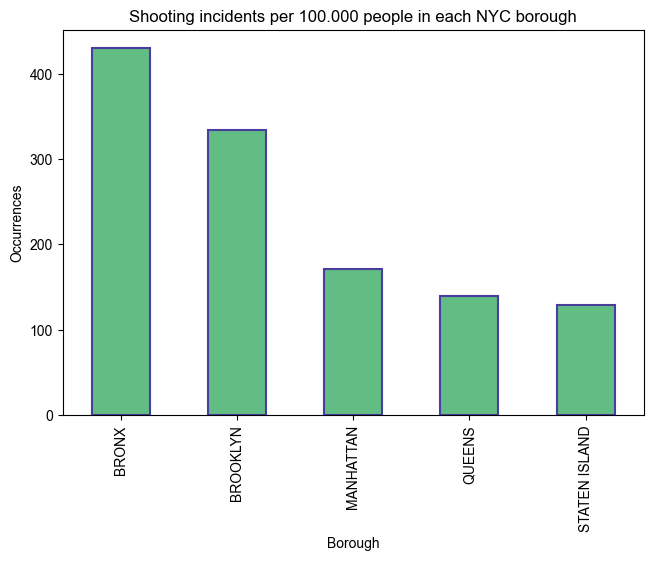

In [85]:
# 2020 consensus population numbers of NYC boroughs in the order: Bronx, Brooklyn, Manhattan, Queens, Staten Island
population_array = np.array([1472654, 2736074, 1694251, 2405464, 495747])
boroughs = ["BRONX", "BROOKLYN", "MANHATTAN", "QUEENS", "STATEN ISLAND"]
fig, ax = plt.subplots(figsize=(7.5,5))

df_subset = df['boro'].value_counts(sort=False)
df_subset = df_subset.sort_index()
df_subset = (df_subset/population_array)*100000
df_subset.plot.bar(ax=ax, title="Shooting incidents per 100.000 people in each NYC borough", ylabel="Occurrences", xlabel="Borough", color=main_col, edgecolor=sec_col, linewidth=1.5)

plt.show()

An interesting statistic to explore further is the lethality statistic. In the plot below we visualize the percentage of shooting incidents which resulted in the death of the shooting victim vs percentage in which the victim survived for all shootings throughout the whole time period.

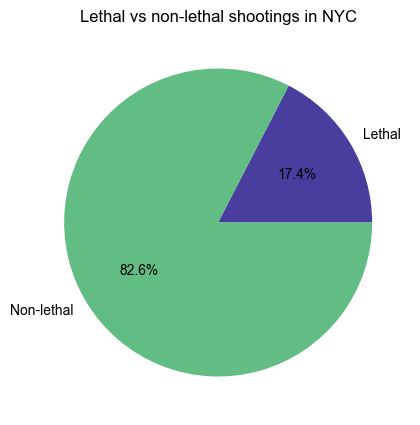

In [86]:
num_lethal_shootings = len(df.loc[df["STATISTICAL_MURDER_FLAG"] == True])
num_nonlethal_shootings = len(df.loc[df["STATISTICAL_MURDER_FLAG"] == False])

labels = 'Lethal', 'Non-lethal'
sizes = [(num_lethal_shootings/len(df))*100, (num_nonlethal_shootings/len(df))*100]

fig, ax = plt.subplots(figsize=(7.5,5))

plt.pie(sizes, labels=labels, colors=[sec_col, main_col], autopct='%1.1f%%')
plt.title("Lethal vs non-lethal shootings in NYC")
plt.show()


<a id='data_analysis'></a>
## **3. Data analysis**

To get a general overview of the number of shooting incidents in NYC, let us visualize how the number of shootings has changed with the years. In figure 1 we see the yearly number of shootings in all of NYC throughout the whole time period. The number of occurences appears relatively stable in the late 2010s followed by a period of significant drop in occurences until the large spike in 2020/2021. In 2022 and 2023 the number of occurences start dropping rapidly again. It is difficult to qualify what caused the prolonged drop in shooting incidents up until 2020, but it is not a phenomenon isolated to NYC. According to a report [[3]](https://bjs.ojp.gov/library/publications/trends-and-patterns-firearm-violence-1993-2018) by BJS, the rate of firearm violence declined significantly in the time period 1993-2018.

The surge of gun violence in 2020 can likely be attributed to a few factors. Firstly, the New York police department (NYPD) saw its resources stretched thin in 2020 due to the outbreak of the Covid-19 pandemic. Additionally, massive protests following the murder of George Floyd further weakened ability of the NYPD to be present in and around the city [[4]](https://www.nyc.gov/site/nypd/news/p0106a/overall-crime-new-york-city-reaches-record-low-2020).

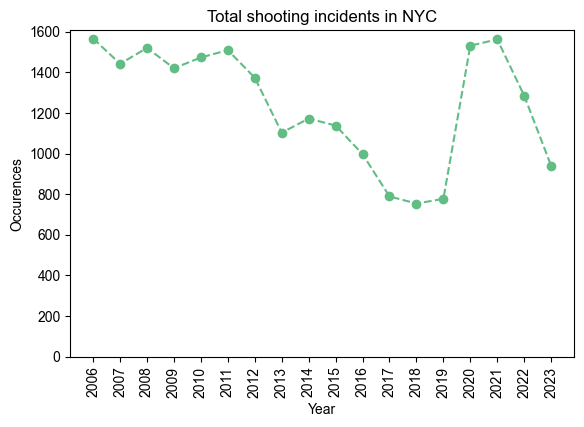

In [87]:
fig, ax = plt.subplots(figsize=(6.5,4.8))
plt.subplots_adjust(bottom=0.2)

# value counts for each year
df_subset = df['year'].value_counts(sort=False)
df_subset = df_subset.sort_index()
idx = df_subset.index
counts = df_subset.values

x = range(len(idx))

# plot values
plt.plot(x, counts, color=main_col, linestyle='--', marker='o')
plt.xticks(x, idx, rotation='vertical')
plt.ylim(0)
plt.title("Total shooting incidents in NYC")
plt.xlabel("Year")
plt.ylabel("Occurences")

plt.savefig("figures/shootings_by_year.png")
plt.show()

Let us take a look at the distribution of shootings across the city. Figure 2 displays an interactive map of NYC in which shooting incidents have been grouped into clusters. It becomes clear that certain parts of NYC are more heavily impacted. Many of the larger clusters are centered around the boroughs Brooklyn and Bronx. In Brooklyn, shooting incidents seem especially prevelant around the Flatbush and Brownsville (East New York) neighbourhoods. In Bronx, areas near Melrose and Tremont are severely impacted. Unsurprisingly, these neighbourhoods are all among the lowest household-income neighbourhoods in NYC [[5]](https://a816-dohbesp.nyc.gov/IndicatorPublic/data-explorer/economic-conditions/?id=103#display=summary).

In [88]:
import folium
from branca.colormap import linear
from folium.plugins import MarkerCluster


# Create dataframe with number of shootings in each borough
geo_df = df['boro'].value_counts(sort=False)
geo_df = geo_df.to_frame()
geo_df.index = ["Bronx", "Brooklyn", "Queens", "Manhattan", "Staten Island"]

# Correct column names
geo_df = geo_df.reset_index()
geo_df.columns = ["BoroName", "Number of shootings"]

geo_df_dict = geo_df.set_index("BoroName")["Number of shootings"]

# create colormap
colormap = linear.Greens_09.scale(0, 10000)

# popups
popup = folium.GeoJsonPopup(fields=["BoroName"])

# define map
Map = folium.Map(tiles="CartoDB Positron", location=[40.70,-73.90], zoom_start=10)

# color boroughs by number of shootings with geojson data
folium.GeoJson(data="data/NYC_NEW.geojson",name="NumShootings",
    style_function=lambda feature: {
        "fillColor": colormap(geo_df_dict[feature["properties"]["BoroName"]]),
        "color": "black",
        "weight": 1,
        # "dashArray": "5, 5",
        "fillOpacity": 0.5,
    },
    popup=popup,
    popup_keep_highlighted=True
    ).add_to(Map)

colormap.caption = "Number of shootings"
colormap.add_to(Map)


# define shooting locations
lat = np.array(df["latitude"])
lon = np.array(df["longitude"])
lat = lat.reshape(len(lat),1)
lon = lon.reshape(len(lon),1)

locations = np.concatenate((lat, lon), axis=1)

# add clusters of shooting points to the map
clust = MarkerCluster().add_to(Map)

for i in range(len(locations)):
    folium.Marker(location=[locations[i,0], locations[i,1]]).add_to(clust)

# save map
Map.save('figures/cluster_map2.html')

# show map
Map

We can also visualize the shootings by individual dots. Let us try to illustrate the lethal vs non-lethal shootings in the year 2020. In the below plot, a green dot indicates a non-lethal shooting whereas a purple dot indicates a lethal shooting.

In [89]:
df_subset = df.loc[(df["year"] == 2020)]

lat = np.array(df_subset["latitude"])
lon = np.array(df_subset["longitude"])
lethal_bool = np.array(df_subset["STATISTICAL_MURDER_FLAG"])
lat = lat.reshape(len(lat), 1)
lon = lon.reshape(len(lon), 1)
lethal_bool = lethal_bool.reshape(len(lethal_bool), 1)

locations = np.concatenate((lat, lon, lethal_bool), axis=1)

# define map
NYC_map = folium.Map(tiles="CartoDB Positron", location=[40.67,-73.90], zoom_start=11)



for i in range(len(locations)):
    if locations[i][2] == False:
        folium.vector_layers.Circle([locations[i][0], locations[i][1]], radius=40, color=main_col, fill=True, fillOpacity=1.0).add_to(NYC_map)

    else:
        folium.vector_layers.Circle([locations[i][0], locations[i][1]], radius=40, color=sec_col, fill=True, fillOpacity=1.0).add_to(NYC_map)


NYC_map

Calendar plots of the daily shooting incidents in NYC in the years 2019-2023. As we also saw earlier, 2020 and 2021 had the highest levels of shooting incidents. Interestingly, shootings seem to be somewhat centered around the summer months with the highest amount of shootings in one day being July 5, 2020 - the day after the national holiday on July 4th.

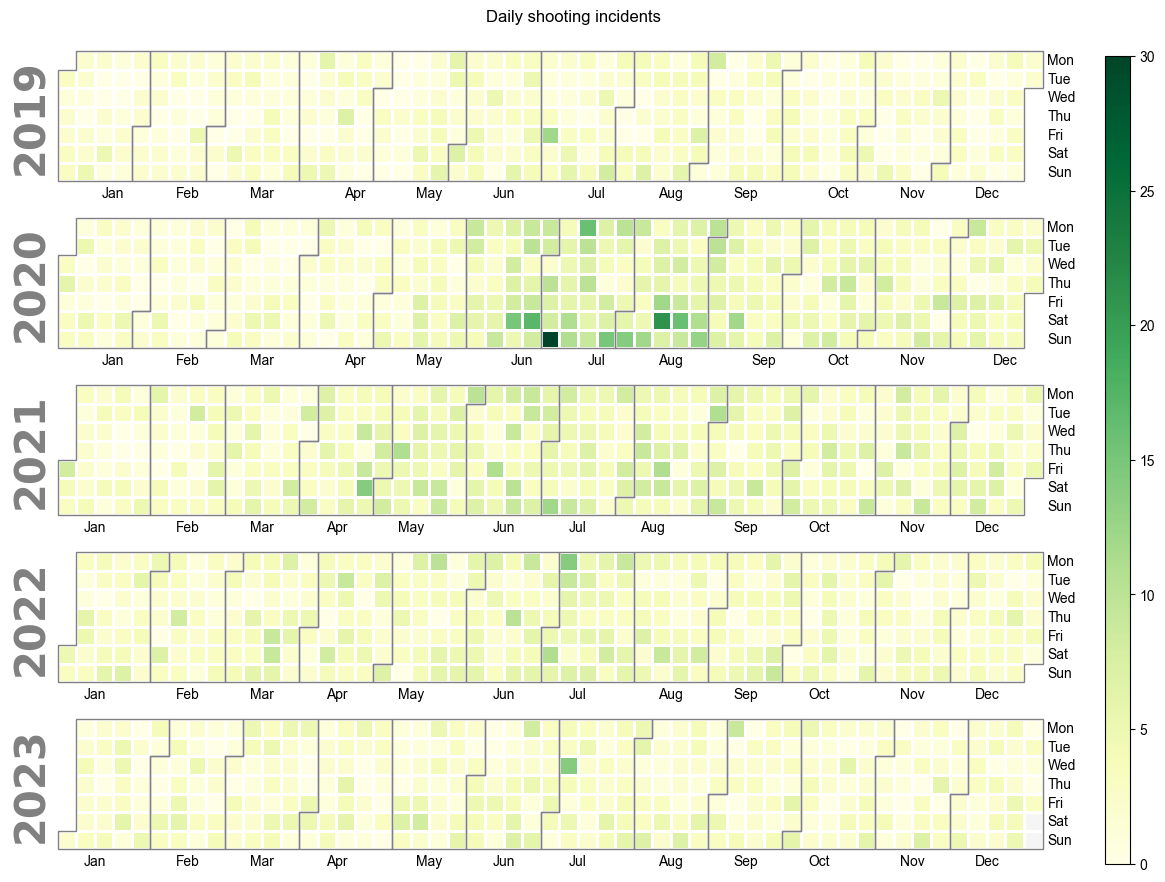

In [90]:
import calplot

df_subset = df.loc[(df["year"] >= 2019)]
events = df_subset['date'].value_counts(sort=False)

calplot.calplot(events, cmap = "YlGn", colorbar=True, suptitle="Daily shooting incidents", yearlabel_kws={'fontname':'sans-serif'})

plt.show()

We now visualize the number of shootings by month for each borough. The plot on figure 3 is interactive and and allows for selection of the borough(s) for which the distribution across the year should be displayed. The general trend is that the summer months are the peak of shooting incidents across for all the five boroughs. This stems with numerous studies (e.g. [[Esfandi]](https://esfandilawfirm.com/do-seasons-weather-affect-crime-trends/#:~:text=According%20to%20the%20U.S.%20Bureau,as%20the%20weather%20gets%20hotter.)) that conclude that violent crime, in general, seems to peak during the summer.

In [91]:
# create helpful dataframe to use for month/borough plot

# list of boroughs
boroughs = list(df["boro"].unique())
counts_list = []
column_names = []

for borough in boroughs:
    df_subset = df.loc[(df["boro"] == borough)]

    # month value counts
    val_count_subset = df_subset["month"].value_counts(sort=False)
    val_count_subset = val_count_subset.sort_index()

    counts_list.append(val_count_subset)
    column_names.append(borough)

dfg = pd.concat(counts_list, axis=1)
dfg.columns = column_names

dfg["idx_col"] = dfg.index
dfg

BRONX  BROOKLYN  QUEENS  MANHATTAN  STATEN ISLAND  idx_col
month                                                            
1        417       556     216        207             46        1
2        297       429     210        149             31        2
3        379       596     228        172             36        3
4        482       671     239        211             49        4
5        571       854     296        268             62        5
6        708       899     343        300             56        6
7        725      1109     366        327             81        7
8        726      1066     375        313             65        8
9        574       902     298        258             55        9
10       522       750     299        243             51       10
11       474       632     224        207             55       11
12       455       666     258        242             55       12

In [92]:
import bokeh.plotting as bk
from bokeh.models import ColumnDataSource, Legend
from bokeh.palettes import Viridis10

src = ColumnDataSource(dfg)

# plot = bk.figure(frame_height=400, frame_width=640, title="Number of shootings by month")
plot = bk.figure(frame_height=350, frame_width=510, title="Number of shootings by month")
plot.add_layout(Legend(), 'left')
bars = {}

for i, district in enumerate(boroughs):
    bars[i] = plot.vbar(x="idx_col",  top=district, color=Viridis10[i+4], source=src, legend_label=district, alpha=0.4, muted_alpha=0.0,  muted = False)

for i in range(len(bars)):
    bars[i].visible = False
plot.legend.click_policy="hide"


dict = {
    1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
    7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"
}
plot.xaxis.axis_label = "Month"
plot.xaxis.ticker = list(range(1, 13))
plot.xaxis.major_label_overrides = dict
plot.yaxis.axis_label = "Occurrences"


# bk.output_file("figures/bokeh_shootings_by_month.html")
bk.output_file("figures/bokeh_shootings_by_month2.html")

bk.show(plot)

So we know that shootings in NYC tend to concentrate around certain neighbourhoods as well as certain months of the year. In order to better characterize the shooters and shooting victims, We display the victim and perpetrator counts for both sexes on figure 4. For this visualization we use only observations of the dataset for which both the age group and the sex of the perpetrator is reported. One should always be careful when ignoring significant parts of the dataset for the purpose of comparison between categories. Doing this, one can potentially introduce unintended bias into the illustration and thus also the analysis. An example could be if e.g. females in the 45-64 age group were heavily over represented among perpetrators that were never caught. For this analysis we choose to make the assumption that all shooting perpetrators are equally likely to be caught/seen (and thus have their demographics reported) regardless of age and sex. Assuming this to be true, we avoid the aforementioned bias.

It should also be noted that the age group intervals for this dataset, unfortunately, are quite broad and not of equal length. As such, we should keep this in mind when comparing the different groups. From the plot a few things become clear. Males are heavily over represented among both shooting victims and shooting perpetrators. Females are much less likely to be victims of a shooting, and even less likely to be the perpetrators. Additionally, males in the age group 18-24 are over represented compared to the much broader age category 25-44. This points towards an issue with gang culture, which is predominantly associated with young males. 

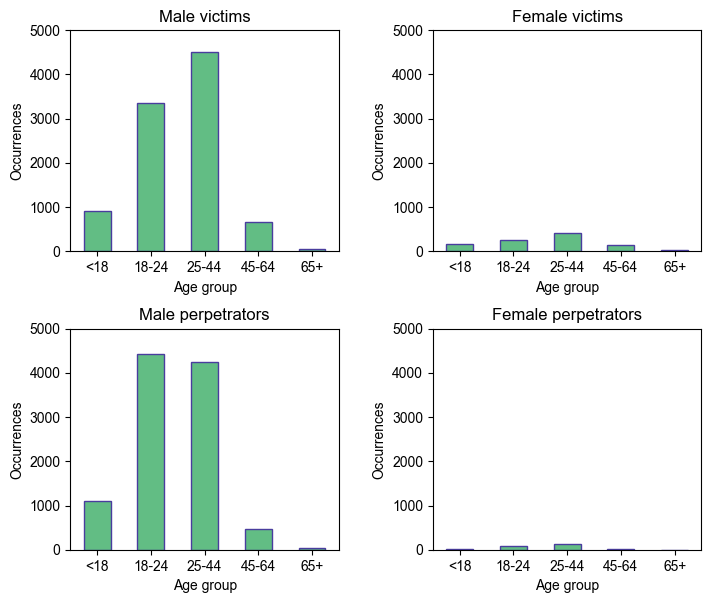

In [93]:
fig, axes = plt.subplots(2, 2, figsize=(7, 6))
# fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes_flat = axes.flatten()
fig.tight_layout()

plt.subplots_adjust(hspace=0.35)
plt.subplots_adjust(wspace=0.35)
plt.subplots_adjust(bottom=0.1)


# remove observations with missing perpetrator information
df2 = df.loc[(~(df["perp_sex"].isnull())) & (~(df["perp_age_group"].isnull()))]

plot_titles=["Male", "Female"]
for i, sex in enumerate(sex_allowed_values):
    df_subset = df2.loc[df2["vic_sex"] == sex]

    # value counts for each age group
    val_count_subset = df_subset["vic_age_group"].value_counts(sort=False)
    val_count_subset = val_count_subset.reindex(index=age_group_allowed_values)

    # plot values
    val_count_subset.plot.bar(ax=axes_flat[i], title=f"{plot_titles[i]} victims", xlabel = "Age group", ylabel="Occurrences", color=main_col, edgecolor=sec_col)
    axes_flat[i].set_ylim(ymax=5000)
    axes_flat[i].set_xticklabels(labels=age_group_allowed_values, rotation=0)

for i, sex in enumerate(sex_allowed_values):
    df_subset = df2.loc[df2["perp_sex"] == sex]

    # value counts for each age group
    val_count_subset = df_subset["perp_age_group"].value_counts(sort=False)
    val_count_subset = val_count_subset.reindex(index=age_group_allowed_values)

    # plot values
    val_count_subset.plot.bar(ax=axes_flat[i+2], title=f"{plot_titles[i]} perpetrators", xlabel = "Age group", ylabel="Occurrences", color=main_col, edgecolor=sec_col)
    axes_flat[i+2].set_ylim(ymax=5000)
    axes_flat[i+2].set_xticklabels(labels=age_group_allowed_values, rotation=0)

plt.savefig("figures/victim_perpetrator_by_sex.png")

plt.show()

The plot in figure 4 opens up an interesting question of the relations between the sexes of perpetrators and victims. As we already know, males are much more likely to be both victims and perpetrators. From the statistics in Table 1 however, we learn something interesting. If we take a look at the two most extreme statistical differences between the sexes, we see that in the case where the perpetrator is female, the victim is about 4 times as likely to be male as they are to be female. I.e. it is not that rare (relatively) for females to shoot other females. On the other hand, if the victim is male, there is only a 1/53 probability that the perpetrator is female. Overall, the key takeaway here is that even though both males and females are most likely to be involved in shootings with males, females are much more likely to be involved in shootings with females, than males are to be involved in shootings with females.

In [94]:
# remove observations with missing perpetrator information
df2 = df.loc[(~(df["perp_sex"].isnull()))]

df_subset1 = df2.loc[df2["vic_sex"] == "M"]
df_subset2 = df2.loc[df2["vic_sex"] == "F"]
df_subset3 = df2.loc[df2["perp_sex"] == "M"]
df_subset4 = df2.loc[df2["perp_sex"] == "F"]

val_count_subset1 = df_subset1["perp_sex"].value_counts(sort=False)
val_count_subset2 = df_subset2["perp_sex"].value_counts(sort=False)
val_count_subset3 = df_subset3["vic_sex"].value_counts(sort=False)
val_count_subset4 = df_subset4["vic_sex"].value_counts(sort=False)

ratio1 = val_count_subset1["M"] / val_count_subset1["F"]
ratio2 = val_count_subset2["M"] / val_count_subset2["F"]
ratio3 = val_count_subset3["M"] / val_count_subset3["F"]
ratio4 = val_count_subset4["M"] / val_count_subset4["F"]

print(f"Male to female perpetrator ratio, given that victim is male: {ratio1}")
print(f"Male to female perpetrator ratio, given that victim is female: {ratio2}")
print(f"Male to female victim ratio, given that perpetrator is male: {ratio3}")
print(f"Male to female victim ratio, given that perpetrator is female: {ratio4}")

Male to female perpetrator ratio, given that victim is male: 53.124378109452735
Male to female perpetrator ratio, given that victim is female: 21.791666666666668
Male to female victim ratio, given that perpetrator is male: 10.208413001912046
Male to female victim ratio, given that perpetrator is female: 4.1875


Another interesting point to investigate based on figure 4 is the relation between age groups of victims and perpetrators. On figure 5 we have a heatmap of the different pairs of victim/perpetrator age groups. Each square is colored according to the number of shootings for that given pair. The heatmap has a somewhat diagonal structure, suggesting that people are more likely to shoot people within their own age group, or at least close to it.

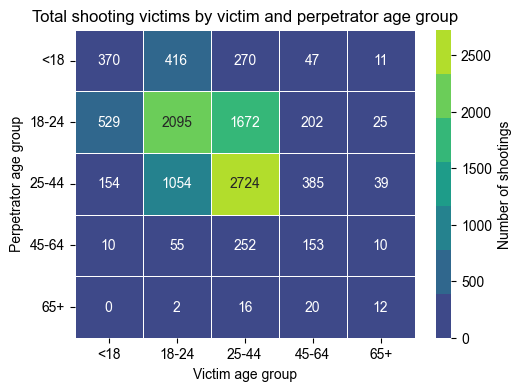

In [95]:
import seaborn as sns

column_order = ['<18', '18-24', '25-44', '45-64', '65+']
index_order = ['<18', '18-24', '25-44', '45-64', '65+']
cmap = sns.color_palette(list(Viridis10[2:-1]), as_cmap=True)

# remove observations with missing perpetrator age group information
df2 = df.loc[(~(df["perp_age_group"].isnull()))]


pt1 = df2.pivot_table(index='perp_age_group', columns='vic_age_group', values='INCIDENT_KEY', aggfunc='count')
pt1 = pt1.reindex(column_order, axis=1)
pt1 = pt1.reindex(index_order, axis=0)
pt1 = pt1.fillna(0)


p = plt.figure(figsize=(8.5, 4))
plt.subplots_adjust(left=0.4)
sns.heatmap(pt1, linewidths=.4, cbar_kws={'label': 'Number of shootings'}, annot=True, fmt='.0f', cmap=cmap)
plt.xlabel('Victim age group')
plt.ylabel('Perpetrator age group')
plt.yticks(rotation='horizontal')
plt.title('Total shooting victims by victim and perpetrator age group')
# plt.savefig("figures/victim_perp_age_groups.png")
plt.show()


One interesting statistic we have not yet discussed is the lethality of shootings and how it changes with different variables. On figure 6 we visualize a heatmap of the lethality ratios (percentage of shootings that are lethal to the victim) of the different pairs of victim age group and victim race. It should be noted that there are a very limited number of shooting incidents for some races, which results in e.g. there being no *lethal* shooting incidents for persons of "american indian/alaskan native" origin. We see that in general, the lethality of shootings tend to increase with the age of the victims. A likely reason for this is that the human body simply is less likely to survive a gunshot the older it gets. Another reason might also be that the level of violence of the type of shootings which older age groups tend to be involved in, is higher. Additionally we see that although black people are more likely to be involved in shootings, the shootings that white people are involved in tend to be more lethal.

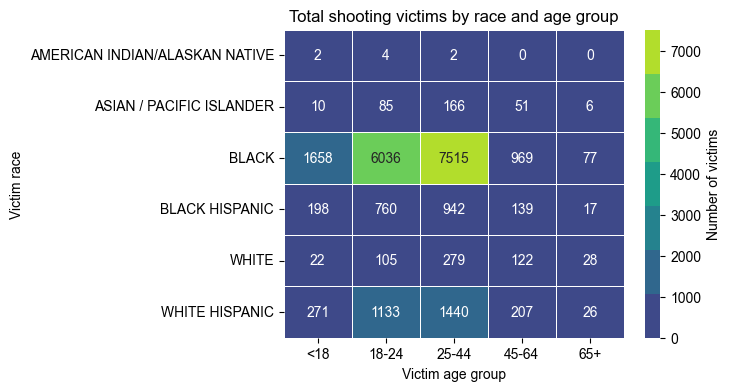

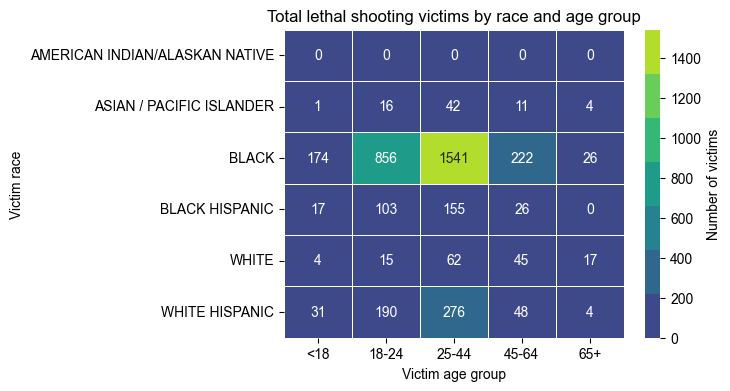

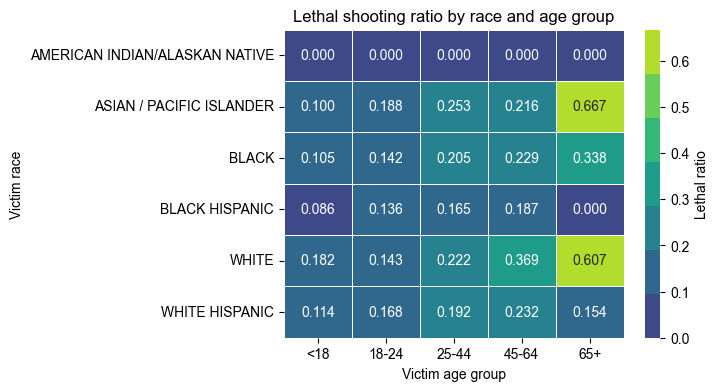

In [96]:


column_order = ['<18', '18-24', '25-44', '45-64', '65+']
index_order = ["AMERICAN INDIAN/ALASKAN NATIVE", "ASIAN / PACIFIC ISLANDER", "BLACK", "BLACK HISPANIC", "WHITE", "WHITE HISPANIC"]
cmap = sns.color_palette(list(Viridis10[2:-1]), as_cmap=True)

# all shootings
df_subset = df

# only lethal shootings
df2 = df_subset.loc[df_subset["STATISTICAL_MURDER_FLAG"] == True]


# create total shooting victims by race and age group pivot table
pt1 = df_subset.pivot_table(index='vic_race', columns='vic_age_group', values='INCIDENT_KEY', aggfunc='count')
pt1 = pt1.reindex(column_order, axis=1)
pt1 = pt1.fillna(0)

# create total lethal shooting victims by race and age group pivot table
pt2 = df2.pivot_table(index='vic_race', columns='vic_age_group', values='INCIDENT_KEY', aggfunc='count')
pt2 = pt2.reindex(column_order, axis=1)
pt2 = pt2.fillna(0)


pt2.loc["AMERICAN INDIAN/ALASKAN NATIVE"] = pd.Series([0, 0, 0, 0, 0], index = age_group_allowed_values)
pt2 = pt2.reindex(index_order, axis=0)


# create lethal shooting ratio pivot table
pt3 = pt2 / pt1
pt3 = pt3.fillna(0)


# plot the three tables as heatmaps where color bar displays total numbers for the first two plots
# and lethal ratio for the third plot
plt.figure(figsize=(8.5, 4))
plt.subplots_adjust(left=0.4)
sns.heatmap(pt1, linewidths=.4, cbar_kws={'label': 'Number of victims'}, annot=True, fmt='.0f', cmap=cmap)
plt.xlabel('Victim age group')
plt.ylabel('Victim race')
plt.title('Total shooting victims by race and age group')
plt.show()


plt.figure(figsize=(8.5, 4))
plt.subplots_adjust(left=0.4)
sns.heatmap(pt2, linewidths=.4, cbar_kws={'label': 'Number of victims'}, annot=True, fmt='.0f', cmap=cmap)
plt.xlabel('Victim age group')
plt.ylabel('Victim race')
plt.title('Total lethal shooting victims by race and age group')
plt.show()


plt.figure(figsize=(8.5, 4))
plt.subplots_adjust(left=0.4)
sns.heatmap(pt3, linewidths=.4, cbar_kws={'label': 'Lethal ratio'}, annot=True, fmt='.3f', cmap=cmap)
plt.xlabel('Victim age group')
plt.ylabel('Victim race')
plt.title('Lethal shooting ratio by race and age group')
# plt.savefig("figures/Lethal_ratio_heatmap.png")
plt.show()


Let us visualize the lethal shooting ratio by year to see whether it has changed over the years. From the below plot, the ratio appears relatively stable. Interesting to note however, is that it seems the dip in total number of shootings that NYC experienced after 2010/2011 was accompanied by a dip in the ratio of lethal shootings. I.e. shooting incidents became both fewer and less violent.

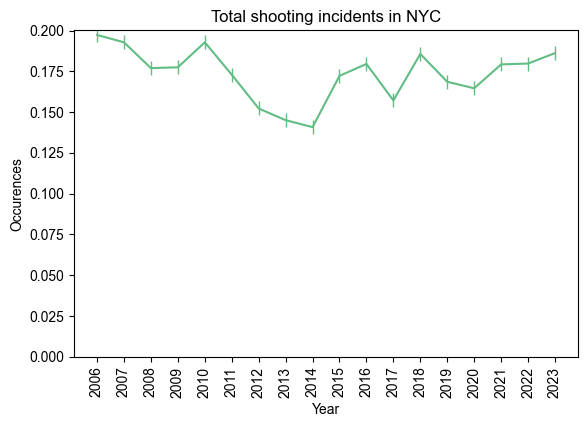

In [97]:

# value counts for each year
val_count_subset = df['year'].value_counts(sort=False)
val_count_subset = val_count_subset.sort_index()
idx = val_count_subset.index
counts = val_count_subset.values

x = range(len(idx))

df2 = df.loc[df["STATISTICAL_MURDER_FLAG"] == True]

val_count_subset2 = df2['year'].value_counts(sort=False)
val_count_subset2 = val_count_subset2.sort_index()
idx2 = val_count_subset2.index
counts2 = val_count_subset2.values

fig, ax = plt.subplots(figsize=(6.5,4.8))
plt.subplots_adjust(bottom=0.2)

# plot values
plt.plot(x, counts2 / counts, color=main_col, marker='|', markersize=10)
plt.xticks(x, idx, rotation='vertical')
plt.ylim(0)
plt.title("Total shooting incidents in NYC")
plt.xlabel("Year")
plt.ylabel("Occurences")

plt.show()

## Summarizing conclusions

Summarizing the findings our analysis of shooting incidents in NYC, we present a few important conclusions. Firstly, there are clear trends in the number of shooting occurences with regards to time and place in NYC. The number of shootings saw a steady decline throughout the years until 2019, when a resurgence in shootings occured. With regards to the different boroughs, Brooklyn and Bronx are by far the most dangerous when it comes to shootings, and hence also the places where the majority of police effort should be focused. Furthermore, in each borough the most dangerous time of the year is during summer. When it comes to demographic patterns, young males unsurprisingly make up the majority of both victim and perpetrator statistics. This aligns with the typical demographics of people involved with criminal gangs. However, it was found that in the case where the victim is female, the perpetrator is much more likely to be female than when the victim is male - and similarly in the case where the perpetrator is female. There are also clear trends in age group data that suggest people are more likely to shoot people in their own age group. These are all general patterns that can potentially narrow down the search of perpetrators for shooting incidents in which the perpetrator has not yet been caught.

<a id='genre'></a>
## **4. Genre**

The overall genre of narrative visualization is magazine style. Presenting the data analysis in a magazine style allows for accompanying text to the visualizations which can help deepen the reader's understanding of the data. It is a choice that allows for more in-depth analysis. 

The main tool I used among the three categories of *visual narrative* from Segal and Heer's paper was feature distinction in order to highlight specific things to the reader. Outside of this, most tools from these categories do not apply well to my website and style of narrative visualization.

From the three categories of narrative structure. From the "ordering" category the *linear* tool is used. The analysis is presented in linear order such that later parts of the data story can build upon earlier parts. The website can still be read/seen in a different order, although this is not the intention. From the "interactivity" category, a number of tools such as *hover highlighting, filtering / selection* and *explicit instruction* are used. On figure 2, the reader can hover their mouse of the different clusters to see the exact area it covers. Figure 3 has explicit instruction on how to navigate the interactive part of the plot in which the reader can select specific boroughs of NYC. From the "messaging" category, tools such as *headlines* and *introductory text* are used. 

<a id='visualizations'></a>
## **5. Visualizations**

I used a number of different types of illustration for this project. Each type of illustration has its pros and cons and has been specifically selected to best present the relevant information to the reader.

- **Regular line graph:** Was used to display the change in the total number of shooting occurences over during the time period. It is probably the most basic type of plot, but it serves its purpose well for this illustration as it is a case of temporal data on the x-axis i.e. there is a certain order to the x-values, they are not just random categories.

- **Interactive cluster map:** An interactive map is a great way to engage the reader in the data with a very "hands on" visualization where the reader has the ability to choose exactly what part of the data they want to look at. This was it becomes more interesting for the reader and useful at the same time since it makes it easier to compare data in different regions in one figure.

- **Interactive bar plot:** Is a great way to, again, give the reader so sort of ability to choose what data the want to see for themselves but also keep it highly informative. A bar plot is also a great choice for this visualization as we can simply make the colors vague such that the bars corresponding to one borough are not disturbed/blocked by the bars corresponding to another borough. This way the reader can potentially visualize the data for all five boroughs at once. A line graph plot could also be an option for this visualization.

- **Bar plot sub plots:** Illustrating related data with only one variable / category changing for each plot is a great way to compare the differences in the variables. Using a bar plot is also the best option for this visualization as the age group category intervals are not of equal length. Although there is an order to the categories, it is less well defined than the order of i.e. the calendar years.

- **Heat map:** A heat map illustration is a very "information dense" way to present information. The plot is 2-dimensional in the way that the data is seperated into the categories of two different categorical features. This way, the reader obtains a highly detailed understanding of how the lethality ratio varies with both features from just a single plot.  



<a id='discussion'></a>
## **6. Discussion**

The overall goal of the project was to use data analysis and visualization to better understand the trends and patterns in the shooting data for NYC. With this goal in mind, I believe the project was fairly successful. The dataset required some data cleaning although this was far from the most time consuming part of the project. It mainly consisted of creating more consistency in the way data was stored with regards to formatting and naming as well as dealing with null values appropriately, adding some relevant columns based on already existing ones, and removing redundant columns. For the data story, I tried to use different narrative visualization techniques while keeping the format within the "magazine" style. I used both interactive as well as static visualizations to give insight into the data. I believe the interactive visualizations are pretty successful in engaging the reader while also presenting insightful information.

There are however still many areas of the project which could be significantly improved. Firstly, the number of interactive visualizations could easily be increased. They are generally more interesting than static visualizations, but I struggled with finding ways to make plots interactive without doing it in an arbitrary or impractical way. For example, I considered making more of the bar plots interactive such that the reader could choose e.g. for which year to view the data, but ended up not doing so as I felt it would simply take away from the overall understanding simply for the sake of making it interactive. This problem however is almost certainly a result of my own lack of creativity as I am sure there are more ways to make the visualizations interactive and insightful at the same time. Another general thing that could be improved is the transitioning between different parts of the data story and the relevancy of each new section in relation to the previous one. I was not quite satisfied with this, as the data story ended up seeming a bit too broad or "all over the place". Lastly, the dataset was perhaps slightly too small in terms of both the number of observations and features. Due to the significant number of missing values in the perpetrator information features, many rows had to be excluded for comparisons where these features were needed. This led to a few cases where the data was not comprehensive enough for accurate analysis. This issue could perhaps have been solved by using a relevant supplementary dataset.

<a id='contributions'></a>
## **7. Contributions**

Bastian Gulstad Ravn (s214727) was the sole contributor to this project.

<a id='references'></a>
## **8. References**

https://en.wikipedia.org/wiki/Boroughs_of_New_York_City

https://www.pewresearch.org/short-reads/2025/03/05/what-the-data-says-about-gun-deaths-in-the-us/ [1]

https://www.healthdata.org/news-events/insights-blog/acting-data/gun-violence-united-states-outlier [2]

https://bjs.ojp.gov/library/publications/trends-and-patterns-firearm-violence-1993-2018 [3]

https://www.nyc.gov/site/nypd/news/p0106a/overall-crime-new-york-city-reaches-record-low-2020 [4]

https://a816-dohbesp.nyc.gov/IndicatorPublic/data-explorer/economic-conditions/?id=103#display=summary [5]
